### Maching Learning

Austin Animal Centre machine learning pipeline

### IMPORTS

In [1]:
// Import other libraries
import java.util.Calendar
import java.io
import java.text.SimpleDateFormat

import spark.implicits._

import scala.math.BigDecimal

import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark._
import org.apache.spark.ml._
import org.apache.spark.ml.feature._
import org.apache.spark.ml.classification._
import org.apache.spark.ml.tree._
import org.apache.spark.ml.evaluation._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.Dataset
import org.apache.spark.sql.functions.udf
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.SparkContext
import org.apache.spark.SparkConf
import org.apache.spark.ml.clustering.LDA
import org.apache.spark.ml.linalg.{Vector, Vectors}
import org.apache.spark.ml.stat.ChiSquareTest
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.mllib.linalg.{VectorUDT, Vectors}
import org.apache.spark.sql.{Row, SQLContext}
import org.apache.spark.sql.types.{StructField, StructType}
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, StringIndexer, StringIndexerModel}
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.mllib.stat.{Statistics => OldStatistics}
import org.apache.spark.mllib.linalg._
import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.rdd.RDD
import org.apache.spark.ml.attribute.Attribute
import org.apache.spark.ml.feature.{VectorIndexer,VectorAssembler,IndexToString}
import org.apache.spark.sql.{SparkSession,Dataset,DataFrame}

Intitializing Scala interpreter ...

Spark Web UI available at http://990ab9a36641:4041
SparkContext available as 'sc' (version = 2.4.3, master = local[*], app id = local-1560165933251)
SparkSession available as 'spark'


2019-06-10 11:25:31,243 WARN  [main] util.NativeCodeLoader (NativeCodeLoader.java:<clinit>(62)) - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2019-06-10 11:25:32,939 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


import java.util.Calendar
import java.io
import java.text.SimpleDateFormat
import spark.implicits._
import scala.math.BigDecimal
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark._
import org.apache.spark.ml._
import org.apache.spark.ml.feature._
import org.apache.spark.ml.classification._
import org.apache.spark.ml.tree._
import org.apache.spark.ml.evaluation._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.Dataset
import org.apache.spark.sql.functions.udf
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.SparkContext
import org.apache.spark.SparkConf
import org.apache.spark.ml.clustering.LDA
import org.apache.spark.ml.linalg...

In [2]:
//read data from Phase 2 wrangling task.
//name the columns required for EDA
val phase2 = spark.read.format("csv").load("not_encoded_output")

val colnames = Array("id_in","name_in","location_found_in","intake_type","intake_condition","species_in","age_years_in",
                     "sex_in","desexed_in","prim_colour_in","sec_colour_in","mix_breed_bool_in","prim_breed_in",
                     "town_found","date_in","time_in","ampm_in","month_in","weekday_in","dob_in","outcome_type",
                     "outcome_subtype","age_years_out","desexed_out","date_out","time_out","ampm_out","month_out",
                     "weekday_out")

val animal_df = phase2.toDF(colnames: _*)

phase2: org.apache.spark.sql.DataFrame = [_c0: string, _c1: string ... 27 more fields]
colnames: Array[String] = Array(id_in, name_in, location_found_in, intake_type, intake_condition, species_in, age_years_in, sex_in, desexed_in, prim_colour_in, sec_colour_in, mix_breed_bool_in, prim_breed_in, town_found, date_in, time_in, ampm_in, month_in, weekday_in, dob_in, outcome_type, outcome_subtype, age_years_out, desexed_out, date_out, time_out, ampm_out, month_out, weekday_out)
animal_df: org.apache.spark.sql.DataFrame = [id_in: string, name_in: string ... 27 more fields]


## Exploratory Data Analysis

Here is an initial look at the data to get an understanding of it's main characteristics.


Unfortunately plotly was not working consistently for all group members in the Almond Kernel. For this reason we have used Python magic cells in our notebook.<br>
Special thanks to Ignatius Soputro for explaining how the Python magic cells work: <br>
https://github.com/isop0001/FIT5202/blob/master/Python%20Cell%20Magic%20in%20Scala%20Notebook/Python%20Cell%20Magic%20in%20Scala%20Notebook.ipynb

### Check the types of animals being brought to the shelter and why:

In [3]:
val antype = animal_df.
  groupBy('species_in).
  agg(count('id_in) as "count").
  orderBy(desc("count"))
antype.show()

2019-06-10 11:26:43,097 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
+----------+-----+
|species_in|count|
+----------+-----+
|       Dog|56954|
|       Cat|36476|
|     Other| 5317|
|      Bird|  462|
| Livestock|   15|
+----------+-----+



antype: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [species_in: string, count: bigint]


In [4]:
val intake = animal_df.
  groupBy('intake_type).
  agg(count('id_in) as "count").
  withColumn("fraction", round(col("count") /  sum("count").over() * 100, 1)).
  orderBy(desc("count"))
intake.show()

2019-06-10 11:27:07,160 WARN  [Thread-4] window.WindowExec (Logging.scala:logWarning(66)) - No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+------------------+-----+--------+
|       intake_type|count|fraction|
+------------------+-----+--------+
|             Stray|69844|    70.4|
|   Owner Surrender|18828|    19.0|
|     Public Assist| 6249|     6.3|
|          Wildlife| 4048|     4.1|
|Euthanasia Request|  255|     0.3|
+------------------+-----+--------+



intake: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [intake_type: string, count: bigint ... 1 more field]


### What outcomes are we aiming to predict:

In [5]:
val outcome = animal_df.
  groupBy('outcome_type).
  agg(count('id_in) as "count").
  orderBy(desc("count"))
outcome.show()

+---------------+-----+
|   outcome_type|count|
+---------------+-----+
|       Adoption|42760|
|       Transfer|29415|
|Return to Owner|18226|
|     Euthanasia| 7104|
|           Died|  892|
|      Rto-Adopt|  388|
|       Disposal|  359|
|        Missing|   54|
|       Relocate|   18|
|        unknown|    8|
+---------------+-----+



outcome: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [outcome_type: string, count: bigint]


From here we allow Python magic cells to assist with scripting plots:

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [6]:
//prepare the spark dataframe to be moved into a python dataframe
animal_df.createOrReplaceTempView("tempDataFrame")

In [7]:
%%python
# create python dataframe for eda
eda_df = spark.sql("select id_in, name_in, location_found_in, intake_type, intake_condition, species_in, age_years_in, sex_in, desexed_in, prim_colour_in, sec_colour_in, mix_breed_bool_in, prim_breed_in, town_found, date_in, time_in, ampm_in, month_in, weekday_in, dob_in, outcome_type, outcome_subtype, age_years_out, desexed_out, date_out, time_out, ampm_out, month_out, weekday_out from tempDataFrame").toPandas()

In [8]:
%%python

# some variables need to be converted as scala has loaded all as an object type by default
import pandas as pd
eda_df['date_in'] = pd.to_datetime(eda_df['date_in'])
eda_df['date_out'] = pd.to_datetime(eda_df['date_out'])
eda_df['dob_in'] = pd.to_datetime(eda_df['dob_in'])
eda_df['age_years_in'] = eda_df['age_years_in'].astype(str).astype(float)
eda_df['age_years_out'] = eda_df['age_years_out'].astype(str).astype(float)

In [9]:
%%python

# view datafrme
eda_df.head()

,id_in,name_in,location_found_in,intake_type,intake_condition,species_in,age_years_in,sex_in,desexed_in,prim_colour_in,sec_colour_in,mix_breed_bool_in,prim_breed_in,town_found,date_in,time_in,ampm_in,month_in,weekday_in,dob_in,outcome_type,outcome_subtype,age_years_out,desexed_out,date_out,time_out,ampm_out,month_out,weekday_out
0,A274546_1,Sophie,Manchaca And Slaughter in Austin (TX),Stray,Normal,Dog,11.0,female,true,tricolor,unknown,true,pointer,Austin (TX),2013-11-13,06:16:00,AM,Nov,Wed,2002-05-25,Adoption,unknown,11.0,true,2013-11-16,12:24:00,PM,Nov,Sat
1,A298677_1,Polly,Manor (TX),Euthanasia Request,Sick,Dog,13.0,female,true,tan,unknown,true,german shepherd,Manor (TX),2015-07-27,12:44:00,PM,Jul,Mon,2002-03-17,Euthanasia,Suffering,13.0,true,2015-07-27,01:59:00,AM,Jul,Mon
2,A443875_1,Sebastian,Austin (TX),Owner Surrender,Normal,Cat,13.0,male,true,gray,white,true,domestic shorthair,Austin (TX),2019-04-07,01:10:00,AM,Apr,Sun,2006-03-21,Adoption,unknown,13.0,true,2019-04-16,04:03:00,AM,Apr,Tue
3,A455146_1,Ruby,Wagon Train Cv in Austin (TX),Stray,Normal,Dog,10.0,female,true,black,brown,true,rottweiler,Austin (TX),2014-12-28,02:05:00,AM,Dec,Sun,2004-06-05,Transfer,Partner,10.0,true,2015-02-07,11:10:00,AM,Feb,Sat
4,A484080_1,Seven,7200 W. Easy Wind Dr. # 1079 in Austin (TX),Public Assist,Normal,Dog,11.0,female,true,gold,unknown,true,labrador retriever,Austin (TX),2016-11-26,11:25:00,AM,Nov,Sat,2005-08-27,Return to Owner,unknown,11.0,true,2016-11-29,12:48:00,PM,Nov,Tue


In [10]:
%%python
#check the basic stats in the dataframe
eda_df.describe(include='all')

,id_in,name_in,location_found_in,intake_type,intake_condition,species_in,age_years_in,sex_in,desexed_in,prim_colour_in,sec_colour_in,mix_breed_bool_in,prim_breed_in,town_found,date_in,time_in,ampm_in,month_in,weekday_in,dob_in,outcome_type,outcome_subtype,age_years_out,desexed_out,date_out,time_out,ampm_out,month_out,weekday_out
count,99224,99224,99224,99224,99224,99224,99224.000000,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224.000000,99224,99224,99224,99224,99224,99224
unique,99224,16734,44645,5,8,5,NaN,3,3,30,35,2,356,27,2057,720,2,12,7,6457,10,22,NaN,3,2057,720,2,12,7
top,A776625_1,unknown,Austin (TX),Stray,Normal,Dog,NaN,male,false,black,unknown,true,domestic shorthair,Austin (TX),2014-07-09 00:00:00,11:01:00,AM,May,Mon,2015-09-01 00:00:00,Adoption,unknown,NaN,true,2016-07-09 00:00:00,12:00:00,AM,May,Sat
freq,1,30965,17994,69844,87409,56954,NaN,47441,61498,24988,32340,92421,29583,82857,140,535,85326,10425,14998,118,42760,54312,NaN,66511,209,2594,87947,9300,15955
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,1991-12-11 00:00:00,NaN,NaN,NaN,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-19 00:00:00,NaN,NaN,NaN,NaN,2019-12-06 00:00:00,NaN,NaN,NaN,NaN,2019-05-19 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.096358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.133003,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.891902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.899889,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN


### Examine monthly frequencies

This dataset runs from a period of October 2013 to May 2019. In order to explore the data by month and make inferences for this, the dataset needs consistent entries for each month. For this reason, the below monthly histograms will only include date from the years 2014 to 2018 to eliminate the incomplete years either side of the dataset.

In [11]:
%%python
# remove 2013 and 2019 data rows
eda_df_2014to2018 = eda_df[(eda_df['date_in'] >= '2014-01-01') & (eda_df['date_in'] < '2019-01-01')]

In [12]:
%%python
# import libraries required for plotting
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile
import seaborn as sns

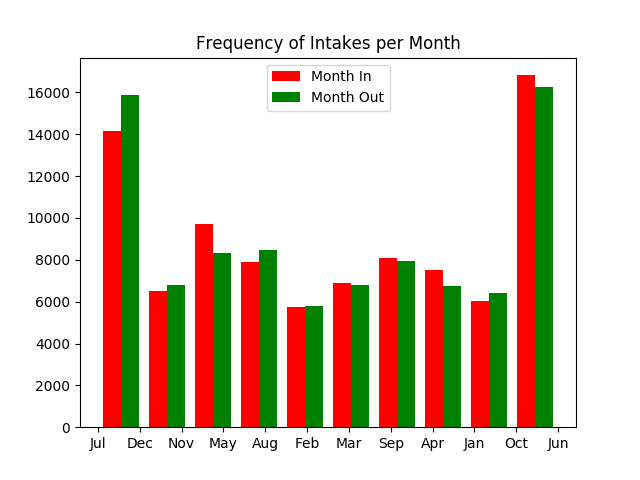

In [13]:
%%python

df_samp = eda_df_2014to2018.sample(n=1000)
month_order = ("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

plt.clf()
plt.hist([eda_df_2014to2018['month_in'], eda_df_2014to2018['month_out']], color=['red', 'green'])
plt.xticks(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("Frequency of Intakes per Month")
plt.legend(["Month In", "Month Out"])
plt.show()
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

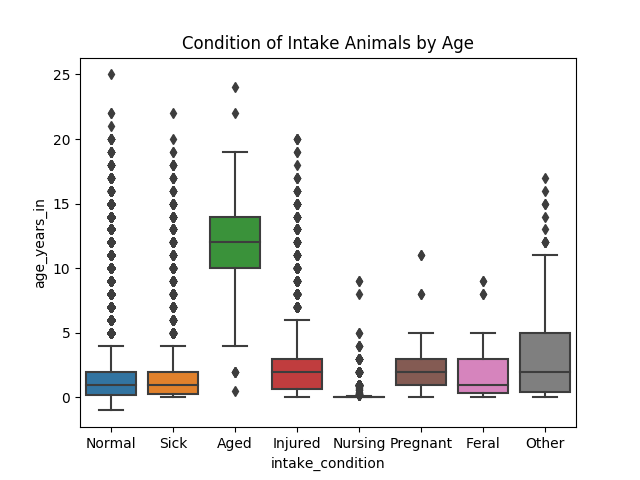

In [14]:
%%python
plt.clf()
sns.boxplot(x='intake_condition', y='age_years_in', data=eda_df, orient='v')
plt.title("Condition of Intake Animals by Age")
plt.show()
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

Since over 90% of animal species types coming into the shelter are cats and dogs, lets examine them closer:

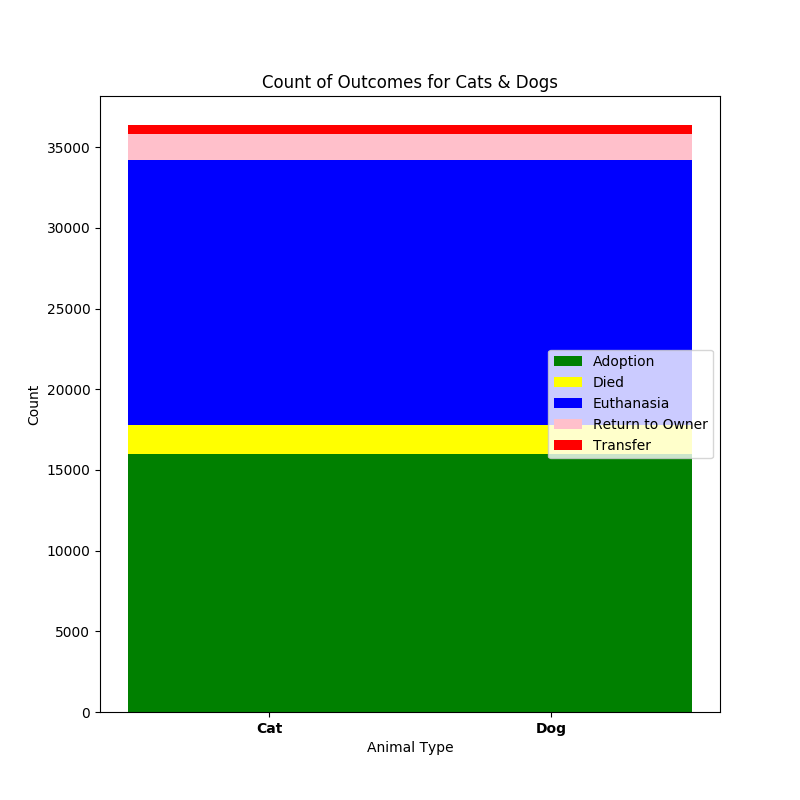

In [17]:
%%python
cd_df = eda_df.groupby(['outcome_type','species_in']).count()[['id_in']].reset_index()

#count for each outcome
adopt = cd_df[cd_df['outcome_type'] == 'Adoption']['id_in']
a = adopt.values[1:2]
died = cd_df[cd_df['outcome_type'] == 'Died']['id_in']
d = died.values[1:2]
euthan = cd_df[cd_df['outcome_type'] == 'Euthanasia']['id_in']
e = euthan.values[1:2]
rto = cd_df[cd_df['outcome_type'] == 'Return to Owner']['id_in']
r = rto.values[1:2]
transfer = cd_df[cd_df['outcome_type'] == 'Transfer']['id_in']
t = transfer.values[1:2]

legend = ['Adoption','Died','Euthanasia','Return to Owner','Transfer']
xaxis = [1,2]
xlab = ['Cat','Dog']

plt.figure(figsize=(8,8))
plt.bar(xaxis, a, color='green', width=1)
plt.bar(xaxis, r, bottom=a, color='yellow', width=1)
plt.bar(xaxis, t, bottom=a+r, color='blue', width=1)
plt.bar(xaxis, e, bottom=a+r+t, color='pink', width=1)
plt.bar(xaxis, d, bottom=a+r+t+e, color='red', width=1)

plt.title('Count of Outcomes for Cats & Dogs');
plt.xticks(xaxis, xlab, fontweight='bold')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.legend(legend,loc='right');
plt.show()

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

### Examine the different animal breeds:

Since an overwhelming number of cats are 'domestic shorthair' breed, we will focus on dogs with a larger variation in breed types. This will give insight into the different breeds coming into the shelter.

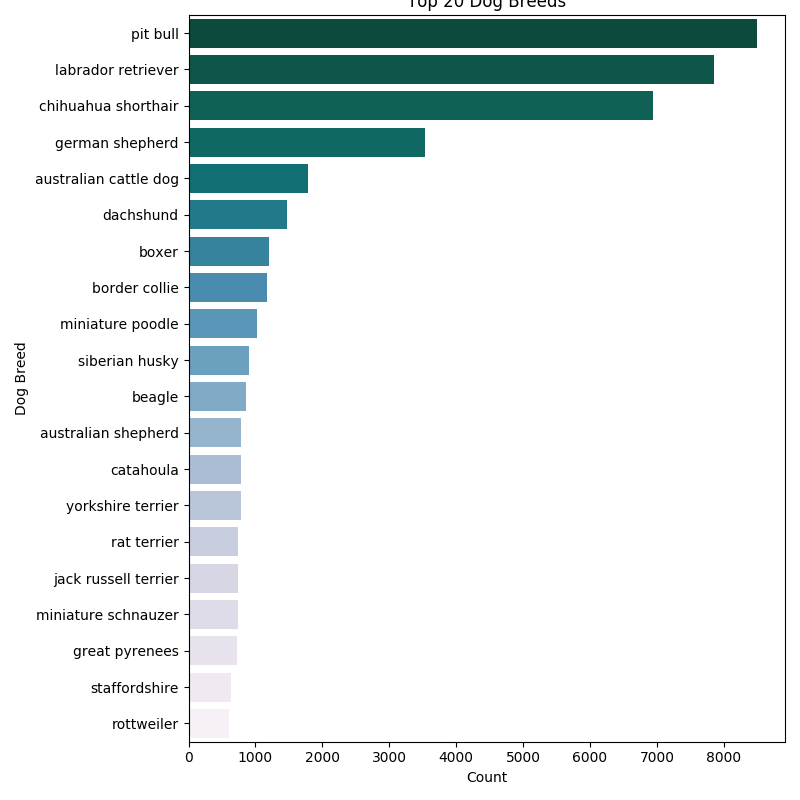

In [18]:
%%python
dogs = eda_df[eda_df['species_in'] == 'Dog']
breed = dogs.groupby(['prim_breed_in']).count()[['id_in']].reset_index().sort_values(by='id_in', ascending=False)
breed_20 = breed.head(20)

# Bar plot
plt.clf()
sns.barplot('id_in','prim_breed_in',data=breed_20, palette='PuBuGn_r', linewidth=0.7)  

plt.tight_layout()
plt.ylabel('Dog Breed')
plt.xlabel('Count')
plt.title('Top 20 Dog Breeds')
plt.show()

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [19]:
%%python
chis = dogs[dogs['prim_breed_in'] == 'chihuahua shorthair']
chis.groupby(['outcome_type','outcome_subtype']).count()

### Examine Primary Animal Colour

Most entries in the dataset have a primary colour of the animal. The below colour examination uses all data entries.

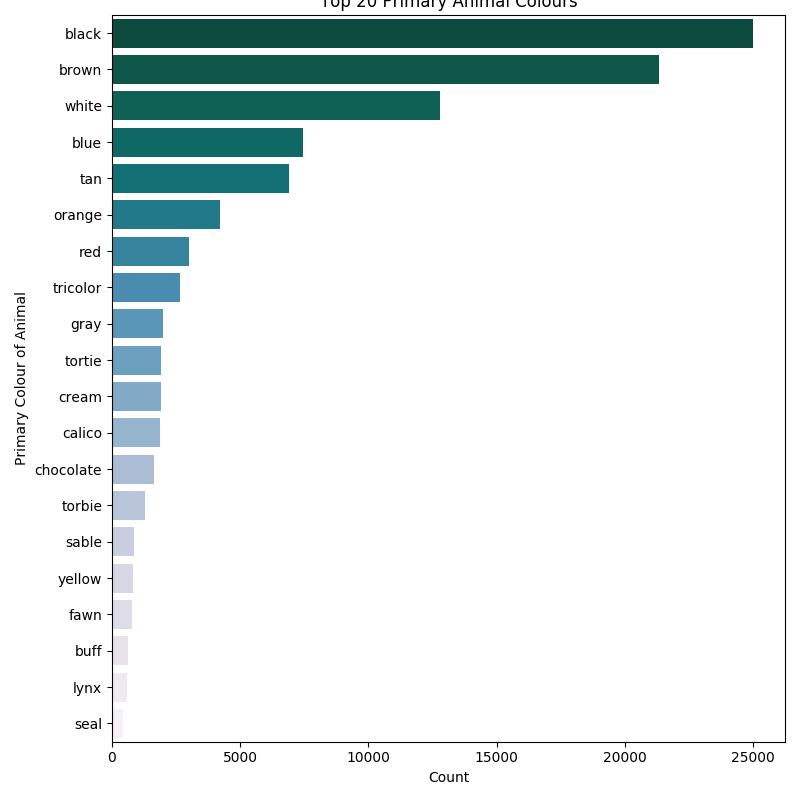

In [20]:
%%python
colours = eda_df.groupby(['prim_colour_in']).count()[['id_in']].reset_index().sort_values(by='id_in', ascending=False)
colours_20 = colours.head(20)

# Bar plot
plt.clf()
sns.barplot('id_in','prim_colour_in',data=colours_20, palette='PuBuGn_r', linewidth=0.7)  

plt.tight_layout()
plt.ylabel('Primary Colour of Animal')
plt.xlabel('Count')
plt.title('Top 20 Primary Animal Colours')
plt.show()

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [21]:
%%python
top_colours = eda_df[(eda_df['prim_colour_in'] == 'black') | (eda_df['prim_colour_in'] == 'brown') |
                    (eda_df['prim_colour_in'] == 'white')]
top_colours.groupby(['outcome_type','prim_colour_in']).count()[['id_in']].reset_index()

In [22]:
%%python
#breed_colour = top_colours[top_colours['outcome_type'] == 'Euthanasia']
#breed_colour.groupby(['prim_breed_in','prim_colour_in']).count()[['id_in']].reset_index().sort_values(by='id_in', ascending=False)

## Correlations

Getting a measure of the correllations between variables will help to choose the most effective variables for the machine learning phase.<br>
First, define some functions to assist with this:

In [23]:
//function get the string from passed in string array that matches the passed in regex
def getMachString (dfSchema: Array[String],pattern: scala.util.matching.Regex): Array[String]={
    var colList = new Array[String](0)
    dfSchema.foreach({ 
        colName :String =>{
            colName match{
                case pattern() => colList = colList :+ colName
                case _ => 
            }
    }})
    return colList
} 

getMachString: (dfSchema: Array[String], pattern: scala.util.matching.Regex)Array[String]


In [24]:
//Passed in column list to generate array of StringIndexer Array
def indexing (indexCols: Array[String]):Array[StringIndexer]={
    var indexers: Array[StringIndexer] = Array()
        indexers = indexCols.toArray.map { 
            colName =>
            new StringIndexer()
                .setInputCol(colName)
                .setOutputCol(colName + "_indexed")
    } 
    return indexers
}

indexing: (indexCols: Array[String])Array[org.apache.spark.ml.feature.StringIndexer]


In [25]:
def corrCal (index_in : DataFrame, index_out: DataFrame):DataFrame={

    var outCols      = index_out.columns
    var inCols       = index_in.columns
    //val in_skip_cols = Array("indexed_id_in_vector","indexed_id_in")

    val crType = "pearson"
    var df = sc.parallelize(inCols).toDF("In_Schema")
    
    //loop through out Columns
    outCols.foreach(outColName => {
        //get the column as a RDD
        var outcol :RDD[Double]= index_out.select(outColName).rdd.map(r=>r.getAs[Double](0))
        
        //Collecting the result as array
        var arrElement = new Array[(String, Double)](0)
        //Loop through in Columns
        inCols.foreach(inColName => {
                try{
                    //get the in column as a RDD
                    var incol:RDD[Double]= index_in.select(inColName).rdd.map(r=>r.getAs[Double](0))
                    
                    //Calculate the pearson correltation
                    var corr:Double = Statistics.corr(incol,outcol,crType)
                    
                    //cast the result to percentage with 2 digit Decimal
                    corr = BigDecimal(corr*100).setScale(2, BigDecimal.RoundingMode.HALF_UP).toDouble
                    
                    //print the result
                    print(s"Correlation of $inColName VS $outColName: $corr\n")
                    
                    //add the result to Array
                    arrElement = arrElement :+ (inColName, corr)
                }catch{
                    case e:Throwable =>{
                        println(s"\nException occur: ${e.printStackTrace()}")
                        arrElement = arrElement :+ (inColName, 0.0)
                    }
                }
        })
        //join the Array as a column of a DataFrame
        df = df.join(sc.parallelize(arrElement)
               .toDF("In_Schema",outColName),Seq("In_Schema"),"inner")
    })
    return df

}

corrCal: (index_in: org.apache.spark.sql.DataFrame, index_out: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


In [26]:
//Function to indexing a DataFrame with giving skip columns and selected column name's regex
def indexingDF(df: DataFrame,skipCols: Array[String],pattern: scala.util.matching.Regex):DataFrame={
    //get full schema names of the database
    val cols = (df.columns.toSet--skipCols.toSet).toArray
    
    //get list of the col needs based on passed in pattern
    val col_list = getMachString(cols,pattern)
    
    //Form new dataframe based on above generated list
    var filt_df  = df.select(col_list.map(c => col(c)): _*)
    
    //form
    val indexers = indexing(col_list)
    indexers.foreach(ind => filt_df = ind.fit(filt_df).transform(filt_df))
    col_list.foreach(name=> filt_df=filt_df.drop(name))
    return filt_df
}

indexingDF: (df: org.apache.spark.sql.DataFrame, skipCols: Array[String], pattern: scala.util.matching.Regex)org.apache.spark.sql.DataFrame


### Run correlation functions:

In [27]:
    val skipCols = Array("name_in","name_out","date_in","date_out"
                         ,"time_in","time_out","dob_in","age_in","town_found"
                         ,"age_out","id_in","id_out","prim_colour_out"
                         ,"sec_colour_out","prim_breed_out")
    val in_cols_regx  = ".*_in$".r
    val out_cols_regx = ".*_out$".r

    //indexed both in and out category columns
    var in_indexed = indexingDF(animal_df,skipCols,in_cols_regx)
    var out_indexed =indexingDF(animal_df,skipCols,out_cols_regx) 

skipCols: Array[String] = Array(name_in, name_out, date_in, date_out, time_in, time_out, dob_in, age_in, town_found, age_out, id_in, id_out, prim_colour_out, sec_colour_out, prim_breed_out)
in_cols_regx: scala.util.matching.Regex = .*_in$
out_cols_regx: scala.util.matching.Regex = .*_out$
in_indexed: org.apache.spark.sql.DataFrame = [sex_in_indexed: double, species_in_indexed: double ... 10 more fields]
out_indexed: org.apache.spark.sql.DataFrame = [ampm_out_indexed: double, desexed_out_indexed: double ... 3 more fields]


In [28]:
%%time
var AACcorr = corrCal(in_indexed,out_indexed)

2019-06-10 11:35:57,877 WARN  [Executor task launch worker for task 1079] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2019-06-10 11:35:57,878 WARN  [Executor task launch worker for task 1079] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
Correlation of sex_in_indexed VS ampm_out_indexed: -2.18
Correlation of species_in_indexed VS ampm_out_indexed: -1.76
Correlation of weekday_in_indexed VS ampm_out_indexed: 0.09
Correlation of desexed_in_indexed VS ampm_out_indexed: 1.48
Correlation of prim_breed_in_indexed VS ampm_out_indexed: 1.68
Correlation of ampm_in_indexed VS ampm_out_indexed: 0.21
Correlation of age_years_in_indexed VS ampm_out_indexed: 1.34
Correlation of location_found_in_indexed VS ampm_out_indexed: -1.56
Correlation of month_in_indexed VS ampm_out_indexed: -0.59
Correlation of sec_colour_in_indexed VS ampm_out_indexed: -0.16
Correlatio

AACcorr: org.apache.spark.sql.DataFrame = [In_Schema: string, ampm_out_indexed: double ... 4 more fields]


In [29]:
AACcorr.createOrReplaceTempView("scdf")

### Visualise correlation output

In [30]:
%%python
# %matplotlib inline
# %matplotlib notebook # Tried both, not needed for animation.
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
from pyspark.sql import SQLContext
from pyspark import SparkContext
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from IPython.display import Image
import tempfile

In [31]:
%%python
sqlContext = SQLContext(sc)
dd = spark.sql("select * from scdf").toPandas()
sp_df= dd.set_index("In_Schema")

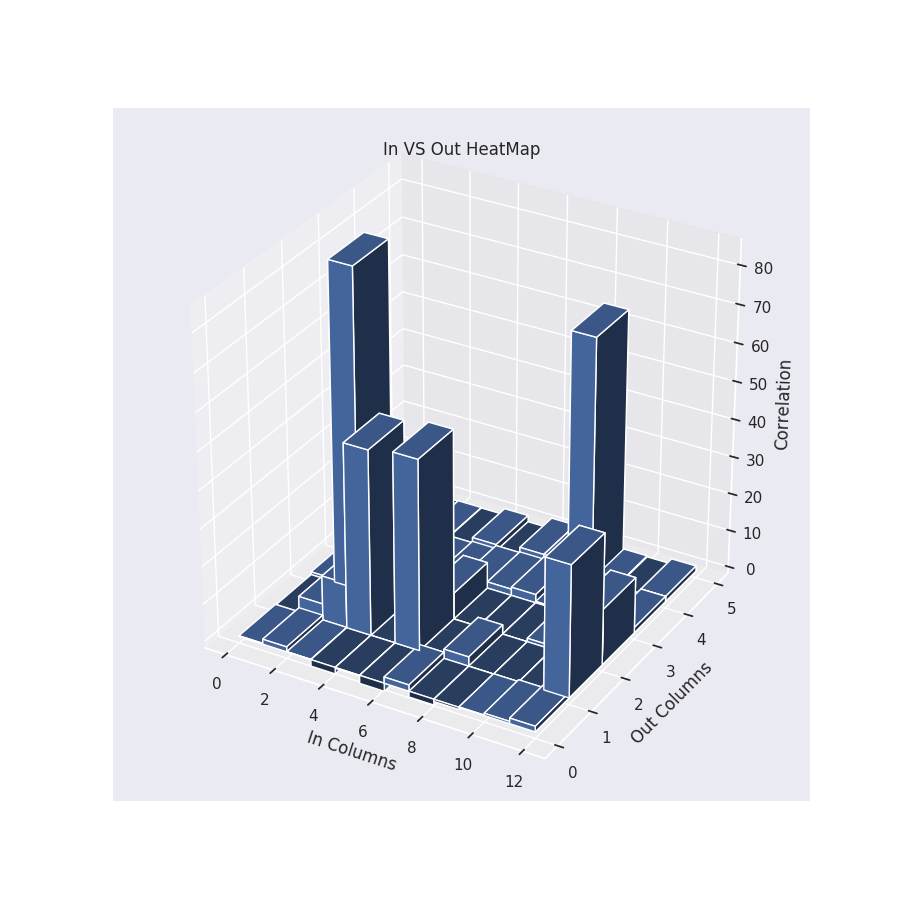

In [32]:
%%python
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# setup the figure and axes
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')


# fake data
_x = np.arange(sp_df.shape[0])
_y = np.arange(sp_df.shape[1])
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

dz = sp_df.values.flatten('F')
z = np.zeros_like(dz)
width = depth = 1

ax.bar3d(x, y, z, width, depth, dz, shade=True)
ax.set_title("In VS Out HeatMap")
ax.set_xlabel('In Columns')
ax.set_ylabel('Out Columns')
ax.set_zlabel('Correlation')

plt.show()
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Machine Learning Pipeline

### FUNCTIONS

In [33]:
// Encoding features for machine learning models

def encode_features_ml(df: DataFrame, target_feat: String, assembled_feat: String): (DataFrame, Array[StringIndexer], StringIndexerModel, VectorAssembler) = {
    // Ensure only categorical columns are encoded
    //val feats = df.columns.filterNot(_.toLowerCase().contains(target_feat)).filterNot(_.toLowerCase().contains("name")).filterNot(_.toLowerCase().contains("date")).filterNot(_.toLowerCase().contains("time")).filterNot(_.toLowerCase().contains("dob")).filterNot(_.toLowerCase().contains("age")).filterNot(_.toLowerCase().contains("id"))
    val feats = df.columns.filterNot(_.toLowerCase().contains("name")).filterNot(_.toLowerCase().contains("date")).filterNot(_.toLowerCase().contains("time")).filterNot(_.toLowerCase().contains("dob")).filterNot(_.toLowerCase().contains("age")).filterNot(_.toLowerCase().contains("id"))
    // Define new encoded columns both indice and vectors
    val indexers = feats.map(name => new StringIndexer()
            .setInputCol(name)
            .setHandleInvalid("keep")
            .setOutputCol(name + "_index")            
    )
    val target_indexer = new StringIndexer()
            .setInputCol(target_feat)
            .setHandleInvalid("keep")
            .setOutputCol(target_feat + "_index")  
    val target_model = target_indexer.fit(df)
    val index_feats = feats.map(_+"_index")
    val feature_assembler = new VectorAssembler() 
            .setInputCols(index_feats)
            .setHandleInvalid("keep")
            .setOutputCol(assembled_feat)
    val pipeline = new Pipeline().setStages(indexers)  // Setting the indexer in the pipeline        
    val df_transformed = pipeline.fit(df).transform(df) // Fitting the encoding pipeline to the dataframe
    val df_return = feature_assembler.transform(df_transformed) // Assembling features into one combined feature
    return (df_return, indexers, target_model, feature_assembler)
}

//read data from Phase 2 wrangling task.
def read_phase2_csv(filename: String): DataFrame = {
    val phase2 = spark.read.format("csv").option("header", "true").load(filename)
   
    val df = phase2.toDF()
    return df
}

encode_features_ml: (df: org.apache.spark.sql.DataFrame, target_feat: String, assembled_feat: String)(org.apache.spark.sql.DataFrame, Array[org.apache.spark.ml.feature.StringIndexer], org.apache.spark.ml.feature.StringIndexerModel, org.apache.spark.ml.feature.VectorAssembler)
read_phase2_csv: (filename: String)org.apache.spark.sql.DataFrame


## Machine Learning Multinomial Classifier Algorithms
### Decision Tree (Random Forest)

In [34]:
// TRAIN DECISION TREE
def train_decision_tree_model(train_data: DataFrame, target_feat: String, assembled_feat: String): RandomForestClassificationModel  = {
    // Define the Random Forest model estimator
    val rf = new RandomForestClassifier()
      .setLabelCol(target_feat + "_index")
      .setFeaturesCol(assembled_feat)
      .setNumTrees(4) 
      .setMaxDepth(3) 
      .setMaxBins(1000)
    
    // Train model with training dataset
    val model = rf.fit(train_data)
    
    return model
} 

// TEST DECISION TREE
def test_decision_tree_model(test_data: DataFrame, model: RandomForestClassificationModel, target_model: StringIndexerModel): DataFrame = {
    // Test model with testing dataset
    var test_pred = model.transform(test_data)
    
    // Decode prediction transformer
    val decoder = new IndexToString()
        .setInputCol("prediction")
        .setOutputCol("prediction_decoded")  
        .setLabels(target_model.labels)
    
    // Generate decoded prediction dataframe
    val test_pred_decoded = decoder.transform(test_pred)
    
    return test_pred_decoded
}

train_decision_tree_model: (train_data: org.apache.spark.sql.DataFrame, target_feat: String, assembled_feat: String)org.apache.spark.ml.classification.RandomForestClassificationModel
test_decision_tree_model: (test_data: org.apache.spark.sql.DataFrame, model: org.apache.spark.ml.classification.RandomForestClassificationModel, target_model: org.apache.spark.ml.feature.StringIndexerModel)org.apache.spark.sql.DataFrame


### Naive Bayes Algorithm

In [35]:
// TRAIN NAIVE BAYES
def train_naive_bayes_model(train_data: DataFrame, target_feat: String, assembled_feat: String): NaiveBayesModel  = {
    // Define Naive Bayes Classifier
    val nb = new NaiveBayes()
        .setLabelCol(target_feat + "_index")
        .setFeaturesCol(assembled_feat)
    
    // Train model with training dataset
    val model = nb.fit(train_data)
    
    return model
} 

// TEST NAIVE BAYES
def test_naive_bayes_model(test_data: DataFrame, model: NaiveBayesModel, target_model: StringIndexerModel): DataFrame = {
    // Test model with testing dataset
    var test_pred = model.transform(test_data)
    
    // Decode prediction transformer
    val decoder = new IndexToString()
        .setInputCol("prediction")
        .setOutputCol("prediction_decoded")  
        .setLabels(target_model.labels)
    
    // Generate decoded prediction dataframe
    val test_pred_decoded = decoder.transform(test_pred)
    
    return test_pred_decoded
}

train_naive_bayes_model: (train_data: org.apache.spark.sql.DataFrame, target_feat: String, assembled_feat: String)org.apache.spark.ml.classification.NaiveBayesModel
test_naive_bayes_model: (test_data: org.apache.spark.sql.DataFrame, model: org.apache.spark.ml.classification.NaiveBayesModel, target_model: org.apache.spark.ml.feature.StringIndexerModel)org.apache.spark.sql.DataFrame


### Logistic Regression Algorithm

In [36]:
// TRAIN LOGISTIC REGRESSION
def train_lr_model(train_data: DataFrame, target_feat: String, assembled_feat: String): LogisticRegressionModel  = {
    // Define Logistic Regressor Classifier
    val lr = new LogisticRegression()
        .setLabelCol(target_feat + "_index")
        .setFeaturesCol(assembled_feat)
        .setMaxIter(10)
        .setRegParam(0.3)
        .setElasticNetParam(0.8)
    
    // Train model with training dataset
    val model = lr.fit(train_data)
    
    return model
} 

//TEST LOGISTIC REGRESSION
def test_lr_model(test_data: DataFrame, model: LogisticRegressionModel, target_model: StringIndexerModel): DataFrame = {
    // Test model with testing dataset
    var test_pred = model.transform(test_data)
    
    // Decode prediction transformer
    val decoder = new IndexToString()
        .setInputCol("prediction")
        .setOutputCol("prediction_decoded")  
        .setLabels(target_model.labels)
    
    // Generate decoded prediction dataframe
    val test_pred_decoded = decoder.transform(test_pred)
    
    return test_pred_decoded
}

train_lr_model: (train_data: org.apache.spark.sql.DataFrame, target_feat: String, assembled_feat: String)org.apache.spark.ml.classification.LogisticRegressionModel
test_lr_model: (test_data: org.apache.spark.sql.DataFrame, model: org.apache.spark.ml.classification.LogisticRegressionModel, target_model: org.apache.spark.ml.feature.StringIndexerModel)org.apache.spark.sql.DataFrame


### Evaluate model

In [37]:
def evaluate_prediction(algorithm_name: String, df: DataFrame, target_feat: String, prediction_col: String) = {
    // Evaluate test data's accuracy
    var evaluator = new MulticlassClassificationEvaluator()
      .setLabelCol(target_feat + "_index")
      .setPredictionCol(prediction_col)
      .setMetricName("accuracy") 
    val accuracy = evaluator.evaluate(df)
    println(s"$algorithm_name - Test dataset: Accuracy=$accuracy")
    
    // Evaluate test data's f1
    evaluator = new MulticlassClassificationEvaluator()
      .setLabelCol(target_feat + "_index")
      .setPredictionCol(prediction_col)
      .setMetricName("f1")
    val f1 = evaluator.evaluate(df)
    println(s"$algorithm_name - Test dataset: F1=$f1")
}

evaluate_prediction: (algorithm_name: String, df: org.apache.spark.sql.DataFrame, target_feat: String, prediction_col: String)Unit


#### Test model

## Machine Learning Output

In [38]:
// Read Phase2 csv
val phase2_df = read_phase2_csv("encoded_output")

// Select features
val selected_join = phase2_df.select(
              "id_in"
              ,"intake_type"
              ,"intake_condition"
              ,"species_in"
              ,"age_years_in"
              ,"sex_in"
              ,"desexed_in"
              ,"prim_colour_in"
              ,"ampm_in"
              ,"month_in"
              ,"weekday_in"
              ,"outcome_type"
              ,"town_found"
)  

// Set target feature
val target_feat = "outcome_type"
val assembled_feat = "assembled_features"

// Encode and index features
val (result, indexers, target_model, assembler) = encode_features_ml(selected_join, target_feat, assembled_feat)

// Create train and test dataset
val Array(train_data, test_data) = result.randomSplit(Array(0.80, 0.20))

// Use Decision Tree (Random Forest) Algorithm
// To predict Outcome Type
// Train model
val decision_tree_model = train_decision_tree_model(train_data, target_feat, assembled_feat)
// Test model
val decision_tree_prediction = test_decision_tree_model(test_data, decision_tree_model, target_model)
// Evaluate model
evaluate_prediction("Decision Tree", decision_tree_prediction, target_feat, "prediction") 

// Use Naive Bayes Algorithm
// To Predict Outcome Type
// Train model
val naive_bayes_model = train_naive_bayes_model(train_data, target_feat, assembled_feat)
// Test model
val naive_bayes_prediction = test_naive_bayes_model(test_data, naive_bayes_model, target_model)
// Evaluate model
evaluate_prediction("Naive Bayes", naive_bayes_prediction, target_feat, "prediction")

// Use Logistic Regression Algorithm
// To Predict Outcome Type
// Train model
val lr_model = train_lr_model(train_data, target_feat, assembled_feat)
// Test model
val lr_prediction = test_lr_model(test_data, lr_model, target_model)
// Evaluate model
evaluate_prediction("Logistic Regression", lr_prediction, target_feat, "prediction")

Decision Tree - Test dataset: Accuracy=0.9475586782750369
Decision Tree - Test dataset: F1=0.9363520542291484
Naive Bayes - Test dataset: Accuracy=0.8102438776029733
Naive Bayes - Test dataset: F1=0.8090818019384828
Logistic Regression - Test dataset: Accuracy=0.43266636118323915
Logistic Regression - Test dataset: F1=0.32238480818370596


phase2_df: org.apache.spark.sql.DataFrame = [id_in: string, name_in: string ... 47 more fields]
selected_join: org.apache.spark.sql.DataFrame = [id_in: string, intake_type: string ... 11 more fields]
target_feat: String = outcome_type
assembled_feat: String = assembled_features
result: org.apache.spark.sql.DataFrame = [id_in: string, intake_type: string ... 23 more fields]
indexers: Array[org.apache.spark.ml.feature.StringIndexer] = Array(strIdx_6e2525762bbb, strIdx_bf55d260190e, strIdx_aa8e5051c2dd, strIdx_c3e66fd453b9, strIdx_ce60f9e4265d, strIdx_17da2b88ba67, strIdx_becb2079ea08, strIdx_36aa732e28d2, strIdx_8efebb50853b, strIdx_42ed3c5ad136, strIdx_29192b667eab)
target_model: org.apache.spark.ml.feature.StringIndexerModel = strIdx_22966d35cef1
assembler: org.apache.spark.ml.feature.V...